# Auto-encoder

In their paper, [Badsha et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7144625/) 
propose a fairly elegant scheme for an auto-encoder for single-cell RNAseq data imputation.


![Figure 1A of Badsha et al. 2020](images/autoencoder.png)
*Figure 1A of Badsha et al. 2020*

In order to reproduce their work, 
first we are going to implement a simple auto-encoder for the gene expression data. 

From there we will see how we can adapt the loss function to focus the learning on the signal in the data (rather than the noise, which is the missing data here). 

Here is their code for inpiration: https://github.com/audreyqyfu/LATE/tree/master

In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


In [2]:
import psutil
import os
def usage():
    '''return RAM usage in Mb'''
    process = psutil.Process(os.getpid())
    ram = process.memory_info()[0] / float(2 ** 20)
    ram = round(ram, 1)
    return ram
usage()

430.2

In [3]:

fname_input = "data/single_cell/example.hd5"
orientation = 'cell_row'  # cell_row/gene_row

In [4]:
df_tmp = pd.read_hdf(fname_input)


number_0 = (df_tmp != 0).sum().sum()

print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

shape is (10000, 949)
non-zero count is 3155953
non-zero rate  is 0.333


In [5]:
# to ease the analysis, we also have a cell type label, extracted from 
# https://github.com/10XGenomics/single-cell-3prime-paper/blob/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv

cell_types = pd.read_csv('data/single_cell/example.cellType.csv' , index_col=0)
cell_types.celltype.value_counts()

celltype
CD8+ Cytotoxic T                3004
CD8+/CD45RA+ Naive Cytotoxic    2450
CD56+ NK                        1266
CD4+/CD25 T Reg                  899
CD19+ B                          878
CD4+/CD45RO+ Memory              428
CD14+ Monocyte                   426
Dendritic                        334
CD4+/CD45RA+/CD25- Naive T       261
CD34+                             37
CD4+ T Helper2                    17
Name: count, dtype: int64

In [6]:
## log10 transformation 
pseudocount = 1

input_df = np.log10( df_tmp.transpose() + pseudocount ).transpose()



In [7]:
m, n = input_df.shape  # m: n_cells; n: n_genes
print('input_matrix: {} cells, {} genes\n'.format(m, n))

print("memory usage: {}Mb".format(usage()))

input_matrix: 10000 cells, 949 genes

memory usage: 598.8Mb


Let's separate training and validation set

In [8]:
valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size


np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_df.iloc[ arr[:train_size] , : ].to_numpy()
X_valid = input_df.iloc[ arr[train_size:] , : ].to_numpy()

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

train: 7000
valid: 3000


In [9]:
cell_type_train = list( cell_types.loc[ input_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_df.index[ arr[train_size:] ] , 'celltype' ] )

In [10]:
gene_ids = input_df.columns

train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]


In [11]:
gc.collect()
print("memory usage: {}Mb".format(usage()))

memory usage: 671.3Mb


In [12]:
%%time
pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]

CPU times: user 1.53 s, sys: 91.4 ms, total: 1.62 s
Wall time: 453 ms


array([0.13283887, 0.05370145, 0.03163334, 0.01239125, 0.00841857,
       0.00777739, 0.00644214, 0.00553098, 0.00445802, 0.00404005])

In [13]:
np.cumsum( pca_valid.explained_variance_ratio_ )[ 100 ]

0.4614508772609625

In [14]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )

CPU times: user 25.3 s, sys: 203 ms, total: 25.5 s
Wall time: 6.38 s


TSNE()

<Axes: >

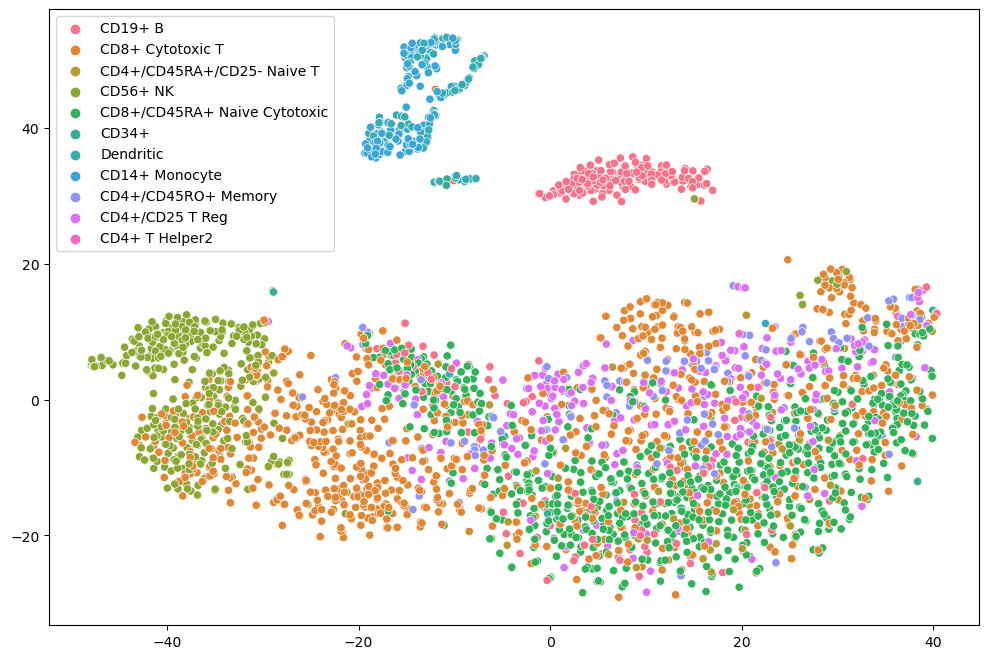

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

## build the data loaders

**exercise:** build the dataLoaders, with a batch size of 256

In [18]:
# %load solutions/AE_dataload.py

# simple autoencoder

## model building

Here we the original paper which uses only 2 layers for the encoder and decoder so we'll follow this design.

Architecture:
 - encoder: 
        - layer input size > hidden size
        - layer hidden size > latent space size
 - decoder:
        - layer latent space size > hidden size
        - layer hidden size > layer input size
    

layer structure : Dropout > linear > ReLU
     


**exercise:** implement the simple auto-encoder with the following specifications:

In [19]:
input_dim = 949  
hidden_dim=[500] 
latent_dim = 100 
[input_dim] + hidden_dim + [latent_dim] + hidden_dim + [input_dim]

[949, 500, 100, 500, 949]

In [ ]:
### test your model with this line:
print(pms.summary(model, torch.zeros(1,949).to(device), show_input=True))

---

In [23]:
# %load solutions/AE_model.py

In [ ]:
### test your model with this line:
print(pms.summary(model, torch.zeros(1,949).to(device), show_input=True))

Our loss at this stage will be the Mean Squared Error between the input and the output:

In [25]:

model.eval()
x, = valid_dataset[:5] ## let's go with a batch of 5 samples

mseloss = nn.MSELoss()

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    print( "input shape:", x.shape)
    print( "prediction shape:", pred.shape)
    print("mean squared error:", mseloss(pred,x))

input shape: torch.Size([5, 949])
prediction shape: torch.Size([5, 949])
mean squared error: tensor(0.1298)


In [26]:
## get the lower dimensional view of a data point:
model.encode(x[0])

tensor([2.2038e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0959e-02, 0.0000e+00,
        6.8061e-02, 1.4895e-01, 2.1402e-02, 0.0000e+00, 1.3223e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9951e-02, 1.1941e-02,
        1.0747e-01, 0.0000e+00, 4.9155e-02, 1.0507e-01, 0.0000e+00, 7.2877e-03,
        0.0000e+00, 0.0000e+00, 8.6673e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.3054e-02, 0.0000e+00, 4.9047e-02, 3.7448e-02, 0.0000e+00,
        1.1449e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6470e-02, 1.1479e-01,
        0.0000e+00, 0.0000e+00, 2.0018e-02, 1.5859e-02, 0.0000e+00, 1.1961e-01,
        0.0000e+00, 1.1085e-02, 0.0000e+00, 0.0000e+00, 8.6980e-02, 2.2160e-03,
        1.2074e-01, 8.8913e-03, 0.0000e+00, 1.1690e-01, 0.0000e+00, 5.1054e-02,
        7.1910e-02, 4.4438e-02, 0.0000e+00, 9.5776e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.0994e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7555e-02,
        0.0000e+00, 0.0000e+00, 6.5283e-

## training the model

In [27]:
def train(dataloader, model, loss_fn, optimizer , patience = 10 ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, X)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()


In [28]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for (X,) in dataloader:
            X = X.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, X).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


In [29]:
## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)


mseloss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) ## using the learning rate from their code


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [30]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )


Train loss: 0.112958  [  256/ 7000]
Train loss: 0.110884  [  512/ 7000]
Train loss: 0.110617  [  768/ 7000]
Train loss: 0.110142  [ 1024/ 7000]
Train loss: 0.109439  [ 1280/ 7000]
Train loss: 0.101042  [ 1536/ 7000]
Train loss: 0.094700  [ 1792/ 7000]
Train loss: 0.094668  [ 2048/ 7000]
Train loss: 0.086965  [ 2304/ 7000]
Train loss: 0.082573  [ 2560/ 7000]
Train loss: 0.077559  [ 2816/ 7000]
Train loss: 0.074534  [ 3072/ 7000]
Train loss: 0.069772  [ 3328/ 7000]
Train loss: 0.067062  [ 3584/ 7000]
Train loss: 0.058443  [ 3840/ 7000]
Train loss: 0.057832  [ 4096/ 7000]
Train loss: 0.057405  [ 4352/ 7000]
Train loss: 0.052314  [ 4608/ 7000]
Train loss: 0.050548  [ 4864/ 7000]
Train loss: 0.048783  [ 5120/ 7000]
Train loss: 0.048277  [ 5376/ 7000]
Train loss: 0.047674  [ 5632/ 7000]
Train loss: 0.046738  [ 5888/ 7000]
Train loss: 0.046215  [ 6144/ 7000]
Train loss: 0.045239  [ 6400/ 7000]
Train loss: 0.044999  [ 6656/ 7000]
Train loss: 0.043561  [ 6912/ 7000]
Train loss: 0.041374  [ 7000

In [31]:
%%time

epoch = 200



for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.035484
Valid Error: 0.035878
Epoch 12
Train loss: 0.025545
Valid Error: 0.026102
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 22
Train loss: 0.024164
Valid Error: 0.025006
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 32
Train loss: 0.022123
Valid Error: 0.023387
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 42
Train loss: 0.021435
Valid Error: 0.023208
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Epoch 52
Train loss: 0.020887
Valid Error: 0.023063
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7

<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

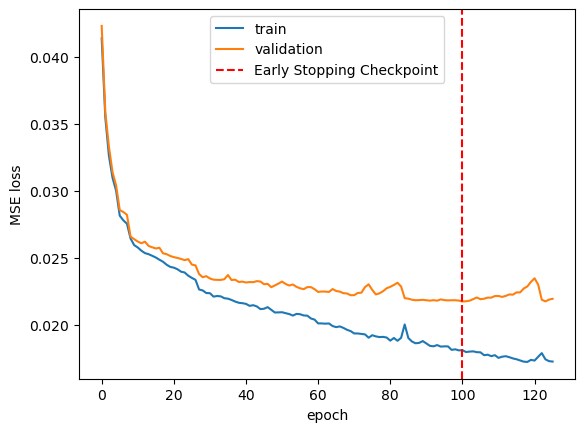

In [32]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [33]:
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )

CPU times: user 30 s, sys: 116 ms, total: 30.2 s
Wall time: 7.55 s


<Axes: >

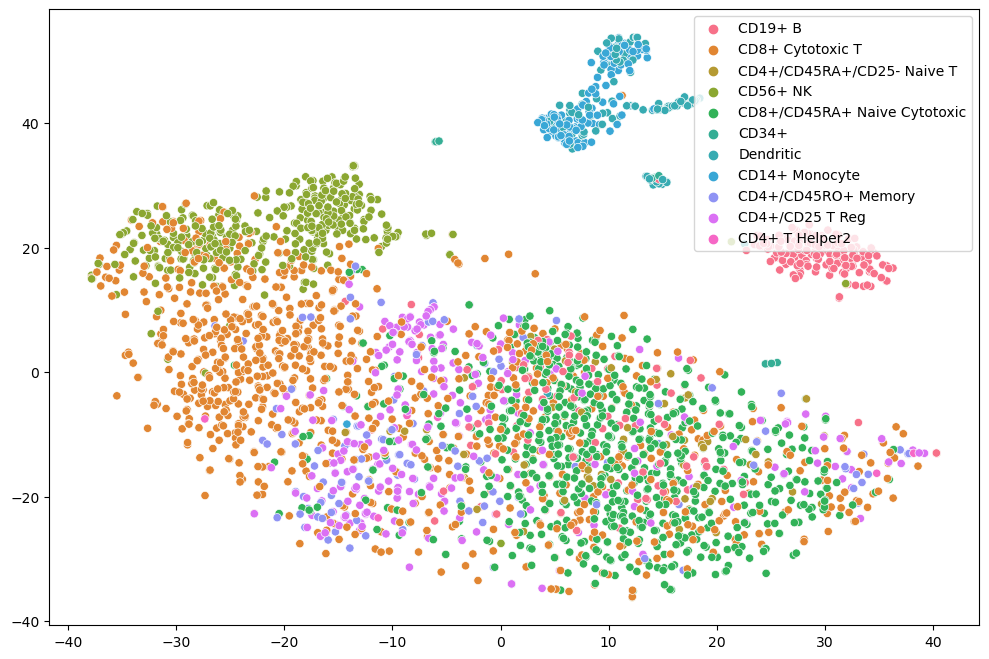

In [34]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

# from autoencoder to imputer

To go from an autoencoder to a imputer, we will switch the loss function to make it focus on the points where we have some data and disregards points were the input data is null.

In [35]:
a = torch.Tensor([[0,1,0,2,0,3],
                  [1,1,0,0,0,3]]) # X
b = torch.Tensor([[1,2,1,1,1,2],
                  [0,2,1,2,1,2]]) # prediction

In [36]:
## basic Squared Error:
(a-b)**2

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 4., 1., 1.]])

In [37]:
a!=0

tensor([[False,  True, False,  True, False,  True],
        [ True,  True, False, False, False,  True]])

In [38]:
## Squared Error where 0s in the original data are masked:
non_zero_mask = (a!=0)
(a-b)**2 * non_zero_mask

tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 1.]])

In [42]:
## and to compute a mean, we sum and divide by the number of non-zeros
SE = torch.sum((a-b)**2 * non_zero_mask)
N0 = torch.sum( non_zero_mask )
SE/N0

tensor(1.)

In [39]:
def maskedMeanSquareError(output, target):
    non_zero_mask = (target!=0)
    SE = torch.sum((output - target)**2 * non_zero_mask)
    N0 = torch.sum(non_zero_mask)
    return SE/N0
maskedMeanSquareError(b, a)

tensor(1.)

In [40]:
x, = valid_dataset[:5]
x = x.to(device)
pred = model(x)

mseloss( pred,x )

tensor(0.0230, grad_fn=<MseLossBackward0>)

In [41]:
maskedMeanSquareError(pred, x)

tensor(0.0476, grad_fn=<DivBackward0>)

### synthetic dataset for testing

In [42]:
## same as the original dataset, but with 90% of 0s
fname_input = "data/single_cell/example.msk90.hd5"
orientation = 'cell_row'  # cell_row/gene_row

In [43]:
df_tmp = pd.read_hdf(fname_input)

number_0 = (df_tmp != 0).sum().sum()

print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

shape is (10000, 949)
non-zero count is 949319
non-zero rate  is 0.100


In [44]:
## log10 transformation 
pseudocount = 1

input_sparse_df = np.log10( df_tmp.transpose() + pseudocount ).transpose()

Let's separate training and validation set

In [45]:
valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size


np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_sparse_df.iloc[ arr[:train_size] , : ].to_numpy()
X_valid = input_sparse_df.iloc[ arr[train_size:] , : ].to_numpy()

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

train: 7000
valid: 3000


In [46]:
cell_type_train = list( cell_types.loc[ input_sparse_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_sparse_df.index[ arr[train_size:] ] , 'celltype' ] )

In [47]:
gene_ids = input_df.columns

train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]

In [48]:
gc.collect()
print("memory usage: {}Mb".format(usage()))

memory usage: 877.8Mb


In [49]:
%%time
pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]

CPU times: user 1.63 s, sys: 32.1 ms, total: 1.66 s
Wall time: 442 ms


array([0.02021433, 0.01943803, 0.01604629, 0.01513427, 0.01421431,
       0.01378829, 0.01338011, 0.01263749, 0.01192714, 0.01152175])

CPU times: user 33.8 s, sys: 176 ms, total: 34 s
Wall time: 8.5 s


<Axes: >

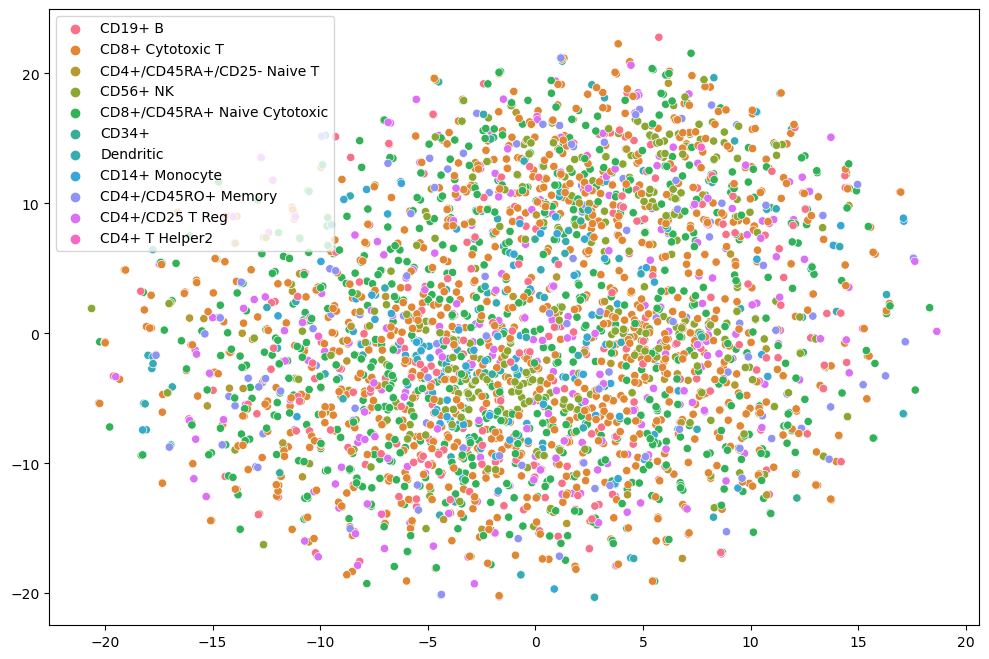

In [50]:
%%time
tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

## build the data loaders

In [51]:
batch_size = 256

In [52]:
# create your dataset
train_dataset = TensorDataset( torch.Tensor(X_train) ) 

## creating a dataloader
train_dataloader = DataLoader( train_dataset , batch_size = batch_size ) 

In [53]:
# create your dataset
valid_dataset = TensorDataset( torch.Tensor(X_valid) ) 

## creating a dataloader
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size )

In [54]:
x, = train_dataset[:]
torch.sum( x == 0 ) / torch.numel( x )

tensor(0.8999)

In [55]:
x, = valid_dataset[:]
torch.sum( x == 0 ) / torch.numel( x )

tensor(0.9001)

## build and train the model

In [56]:
## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)



#############################################
## Here we specify our custom loss function
mseloss = maskedMeanSquareError
#############################################


optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) ## using the learning rate from their code


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [57]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )


Train loss: 0.342256  [  256/ 7000]
Train loss: 0.341526  [  512/ 7000]
Train loss: 0.336091  [  768/ 7000]
Train loss: 0.333062  [ 1024/ 7000]
Train loss: 0.333566  [ 1280/ 7000]
Train loss: 0.318455  [ 1536/ 7000]
Train loss: 0.304848  [ 1792/ 7000]
Train loss: 0.311420  [ 2048/ 7000]
Train loss: 0.296092  [ 2304/ 7000]
Train loss: 0.289294  [ 2560/ 7000]
Train loss: 0.269981  [ 2816/ 7000]
Train loss: 0.258824  [ 3072/ 7000]
Train loss: 0.233721  [ 3328/ 7000]
Train loss: 0.215787  [ 3584/ 7000]
Train loss: 0.194986  [ 3840/ 7000]
Train loss: 0.181898  [ 4096/ 7000]
Train loss: 0.160100  [ 4352/ 7000]
Train loss: 0.147143  [ 4608/ 7000]
Train loss: 0.141678  [ 4864/ 7000]
Train loss: 0.134857  [ 5120/ 7000]
Train loss: 0.139183  [ 5376/ 7000]
Train loss: 0.134803  [ 5632/ 7000]
Train loss: 0.127410  [ 5888/ 7000]
Train loss: 0.108281  [ 6144/ 7000]
Train loss: 0.100041  [ 6400/ 7000]
Train loss: 0.090239  [ 6656/ 7000]
Train loss: 0.084126  [ 6912/ 7000]
Train loss: 0.077952  [ 7000

In [58]:
%%time

epoch = 200



for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.056042
Valid Error: 0.054967
Epoch 12
Train loss: 0.033419
Valid Error: 0.034753
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 22
Train loss: 0.028863
Valid Error: 0.033522
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 32
Train loss: 0.027177
Valid Error: 0.030646
Epoch 42
Train loss: 0.024277
Valid Error: 0.028107
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 52
Train loss: 0.020117
Valid Error: 0.026164
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 1 out of 25
Epoch 62
Train loss: 0.018356
Valid Error: 0.026058
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlySt

<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

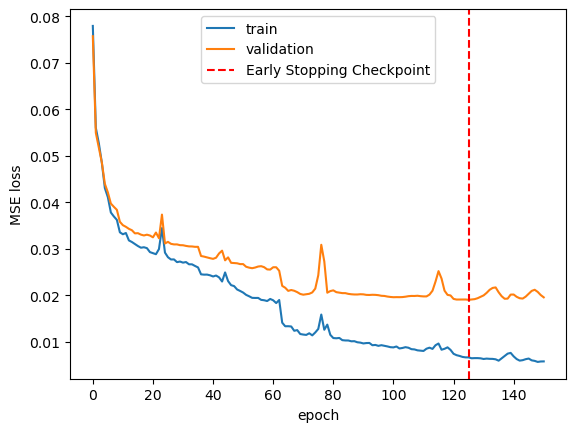

In [59]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [60]:
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )

CPU times: user 30.6 s, sys: 168 ms, total: 30.8 s
Wall time: 7.69 s


<Axes: >

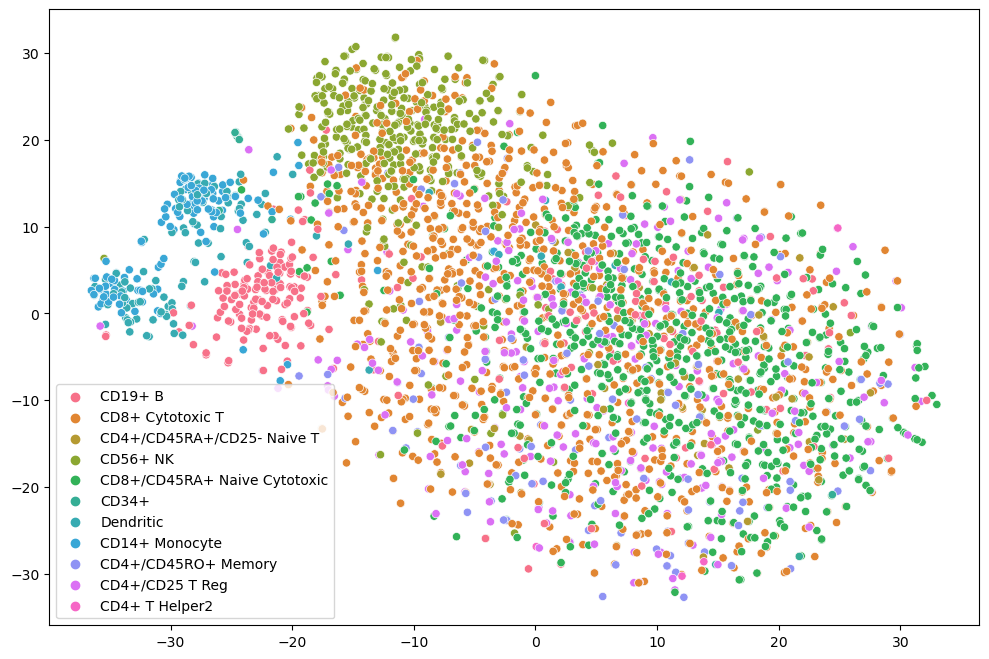

In [61]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

Looks like our masked encoder has retrieved some of the data structure despite the heavy sparsity!

In [62]:
## imputation 
with torch.no_grad():
    x, = train_dataset[:]
    train_imputed = model( x.to(device) ).cpu().numpy()
    x, = valid_dataset[:]
    valid_imputed = model( x.to(device) ).cpu().numpy()


In [63]:
## ground truth
df_truth = pd.read_hdf('data/single_cell/example.hd5')
## log10 transformation 
pseudocount = 1
df_truth = np.log10( df_truth.transpose() + pseudocount ).transpose()

In [64]:
truth_train = np.array( df_truth.loc[ train_cell_ids , : ] )
truth_valid = np.array( df_truth.loc[ valid_cell_ids , : ] )

In [65]:
## remember, the "ground truth" data already had ~67% of missing data, 
##  we do not want to focus on this for the solution assessment

train_NI_mask = ( truth_train != 0 ) & ( X_train != 0 ) # non imputed data
train_I_mask = ( truth_train != 0 ) & ( X_train == 0 ) # imputed data with a ground truth

valid_NI_mask = ( truth_valid != 0 ) & ( X_valid != 0 ) # non imputed data
valid_I_mask = ( truth_valid != 0 ) & ( X_valid == 0 ) # imputed data with a ground truth


In [66]:

# difference of non imputed in train
train_non_imputed_diff = ( train_imputed[ train_NI_mask ] - truth_train[ train_NI_mask ] )
# difference of imputed in train
train_imputed_diff = ( train_imputed[ train_I_mask ] - truth_train[ train_I_mask ] )

# difference of non imputed in valid
valid_non_imputed_diff = ( valid_imputed[ valid_NI_mask ] - truth_valid[ valid_NI_mask ] )
# difference of imputed in valid
valid_imputed_diff = ( valid_imputed[ valid_I_mask ] - truth_valid[ valid_I_mask ] )



CPU times: user 12.9 s, sys: 408 ms, total: 13.3 s
Wall time: 10.8 s


<Axes: >

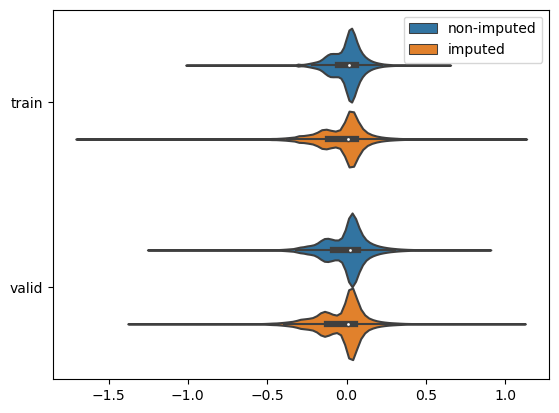

In [67]:
%%time

sizes = (train_non_imputed_diff.shape[0],
         train_imputed_diff.shape[0],
         valid_non_imputed_diff.shape[0],
         valid_imputed_diff.shape[0])

sns.violinplot(x = np.concatenate( [train_non_imputed_diff ,
                                    train_imputed_diff , 
                                    valid_non_imputed_diff, 
                                    valid_imputed_diff]),
            y = ['train']*(sizes[0]+sizes[1]) + ['valid']*(sizes[2]+sizes[3]),
            hue = ['non-imputed']*sizes[0] + ['imputed']*sizes[1] + ['non-imputed']*sizes[2] + ['imputed']*sizes[3] )

In [68]:

print('train, non-imputed - absolute error:')
V = np.abs(train_non_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('train, imputed - absolute error:')
V = np.abs(train_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('valid, non-imputed - absolute error:')
V = np.abs(valid_non_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('valid, imputed - absolute error:')
V = np.abs(valid_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))

train, non-imputed - absolute error:
	q0.05: 0.0051 , q0.5: 0.0564 , q0.95: 0.2036
train, imputed - absolute error:
	q0.05: 0.0063 , q0.5: 0.0761 , q0.95: 0.3151
valid, non-imputed - absolute error:
	q0.05: 0.0070 , q0.5: 0.0749 , q0.95: 0.2902
valid, imputed - absolute error:
	q0.05: 0.0062 , q0.5: 0.0758 , q0.95: 0.3271
